In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
# используем api yandex disk
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/jj6FG3ZFHdCWAQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

In [6]:
# загружаем файл в df 
matches = pd.read_csv(download_url)

In [7]:
matches.head()

,fbref_match_id,season,match_week,match_date,match_time,home_team_name,away_team_name,score,match_result,home_team_score,...,away_team_fouls,away_team_corners,away_team_crosses,away_team_touches,away_team_interceptions,away_team_aerials_won,away_team_offsides,away_team_goal_kicks,away_team_throw_ins,away_team_long_balls
0,d192bd78,2014-2015,1,2014-08-16,12:45,Manchester United,Swansea City,1:2,A,1,...,14,NaN,28,NaN,17,NaN,1.0,NaN,NaN,NaN
1,0a235dd1,2014-2015,1,2014-08-16,15:00,Stoke City,Aston Villa,0:1,A,0,...,14,NaN,18,NaN,17,NaN,1.0,NaN,NaN,NaN
2,36e3a824,2014-2015,1,2014-08-16,15:00,Leicester City,Everton,2:2,D,2,...,16,NaN,16,NaN,18,NaN,NaN,NaN,NaN,NaN
3,49405949,2014-2015,1,2014-08-16,15:00,Queens Park Rangers,Hull City,0:1,A,0,...,7,NaN,33,NaN,10,NaN,0.0,NaN,NaN,NaN
4,5d6474b7,2014-2015,1,2014-08-16,15:00,West Ham United,Tottenham Hotspur,0:1,A,0,...,10,NaN,28,NaN,19,NaN,NaN,NaN,NaN,NaN


In [8]:
matches.dtypes

fbref_match_id            object
season                    object
match_week                 int64
match_date                object
match_time                object
                          ...   
away_team_aerials_won    float64
away_team_offsides       float64
away_team_goal_kicks     float64
away_team_throw_ins      float64
away_team_long_balls     float64
Length: 65, dtype: object

In [9]:
matches['target'] = (matches['match_result'] == 'H').astype('int')

In [10]:
matches['match_date'] = pd.to_datetime(matches['match_date'])
matches['year'] = matches['match_date'].apply(lambda time: time.year)
matches['month'] = matches['match_date'].apply(lambda time: time.month)
matches['day'] = matches['match_date'].apply(lambda time: time.day)
matches['hour'] = matches['match_time'].str.replace(':.+', '', regex=True).astype('int')

In [11]:
train = matches[matches['match_date'] < '2023-01-01']
test = matches[matches['match_date'] >= '2023-01-01']

In [13]:
features = ['home_team_name', 'away_team_name', 'year', 'month', 'day', 'hour', 'venue', 'home_team_manager', 'away_team_manager', 'season']

In [14]:
train_dict = train[features].to_dict(orient='records')

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

dv.fit(train_dict)

DictVectorizer(sparse=False)

In [17]:
X_train = dv.transform(train_dict)

In [18]:
model = LogisticRegression(solver='liblinear', C=2.0, random_state=1)

In [19]:
model.fit(X_train, train['target'])

LogisticRegression(C=2.0, random_state=1, solver='liblinear')

In [20]:
test_dict = test[features].to_dict(orient='records')
X_test = dv.transform(test_dict)
y_pred = model.predict_proba(X_test)[:, 1]

In [21]:
win = y_pred >= 0.5

In [22]:
(test['target'] == win).mean()

0.6666666666666666

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [24]:
accuracy_score(test['target'], win)

0.6666666666666666

In [25]:
roc_auc_score(test['target'], win)

0.6645381013197105

In [26]:
fpr, tpr, thresholds = roc_curve(test['target'], win)

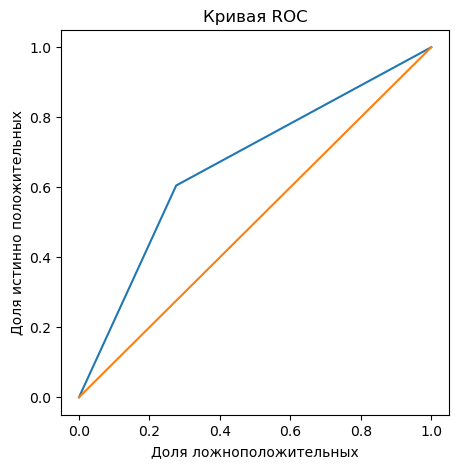

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.title("Кривая ROC")
plt.xlabel("Доля ложноположительных")
plt.ylabel("Доля истинно положительных")
plt.plot([0, 1], [0, 1])